In [ ]:
# %pip install osmx osmx

In [1]:
# %pip install osmx osmnx
import osmnx as ox
import geopandas as gpd

In [2]:
latitude = 52.69238 
longitude = 16.78041
radius = 2000  # Buffer radius in meters
# Step 2: Fetch forest polygons

forest_tags = {"landuse": "forest", "natural": "wood"}  # Forest-related tags
forest_gdf = ox.features.features_from_point((latitude, longitude), tags=forest_tags, dist=radius)

pavement_tags = {"highway": ["footway", "track", "path", "cycleway"]}
pavements_gdf = ox.features.features_from_point((latitude, longitude), tags=pavement_tags, dist=radius)


In [3]:
pavements_gdf['highway'].value_counts()

highway
track      63
path        8
footway     2
Name: count, dtype: int64

In [4]:
forest_gdf = forest_gdf.to_crs(epsg=4326)
pavements_gdf = pavements_gdf.to_crs(epsg=4326)

In [5]:
pavements_in_forests = gpd.sjoin(pavements_gdf, forest_gdf, how="inner", op="intersects")

C:\Users\mkami\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

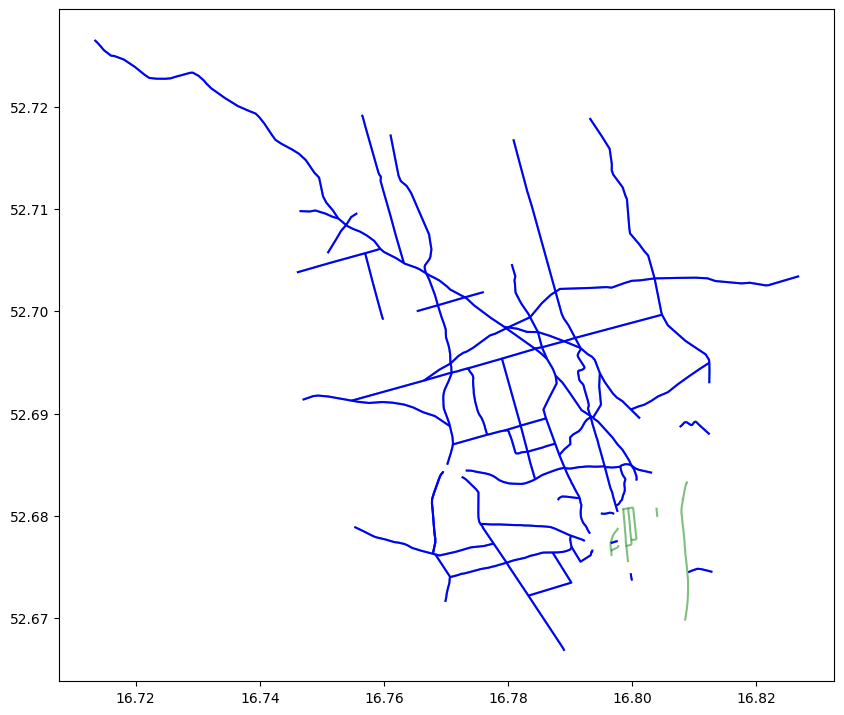

In [8]:
ax = pavements_gdf.plot(color="green", alpha=0.5, figsize=(10, 10), edgecolor="darkgreen")
pavements_in_forests.plot(ax=ax, color="blue", edgecolor="blue")

In [9]:
pavements_gdf = pavements_gdf.explode(index_parts=True)

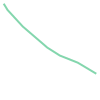

In [10]:
pavements_gdf.iloc[0].geometry

In [11]:
pavements_gdf = pavements_gdf[pavements_gdf.geometry.type == "LineString"]  # Filter LineStrings only

In [12]:
# pavements_gdf = pavements_gdf.to_crs(epsg=4326)

In [13]:
from shapely.geometry import LineString, Point
import pandas as pd

In [14]:
start_points = pavements_gdf.geometry.apply(lambda geom: Point(geom.coords[0]))
end_points = pavements_gdf.geometry.apply(lambda geom: Point(geom.coords[-1]))

In [15]:
nodes_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(pd.concat([start_points, end_points])).drop_duplicates())
nodes_gdf = nodes_gdf.reset_index(drop=True)

In [16]:
# Add x and y columns (longitude and latitude)
nodes_gdf["x"] = nodes_gdf.geometry.x
nodes_gdf["y"] = nodes_gdf.geometry.y

# Assign a unique ID to each node
nodes_gdf["node_id"] = nodes_gdf.index

In [17]:
nodes_gdf

,geometry,x,y,node_id
0,POINT (16.79462 52.69427),16.794616,52.694275,0
1,POINT (16.79988 52.68496),16.799880,52.684957,1
2,POINT (16.81296 52.67453),16.812959,52.674535,2
3,POINT (16.79937 52.67549),16.799370,52.675491,3
4,POINT (16.78912 52.66684),16.789116,52.666837,4
...,...,...,...,...
111,POINT (16.80884 52.68315),16.808836,52.683154,111
112,POINT (16.79784 52.67715),16.797837,52.677149,112
113,POINT (16.79776 52.67885),16.797759,52.678846,113
114,POINT (16.79769 52.67754),16.797693,52.677539,114


In [18]:
def map_point_to_node_id(point, nodes):
    return nodes[nodes.geometry == point].iloc[0]["node_id"]

pavements_gdf["u"] = pavements_gdf.geometry.apply(lambda geom: map_point_to_node_id(Point(geom.coords[0]), nodes_gdf))
pavements_gdf["v"] = pavements_gdf.geometry.apply(lambda geom: map_point_to_node_id(Point(geom.coords[-1]), nodes_gdf))


In [19]:
G = ox.utils_graph.graph_from_gdfs(nodes_gdf, pavements_gdf)

C:\Users\mkami\AppData\Local\Temp\ipykernel_14140\1112226291.py:1: FutureWarning: The `graph_from_gdfs` function has moved to the `convert` module. Calling `utils_graph.graph_from_gdfs` is deprecated and will be removed in the v2.0.0 release. Call it via `convert.graph_from_gdfs` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.utils_graph.graph_from_gdfs(nodes_gdf, pavements_gdf)


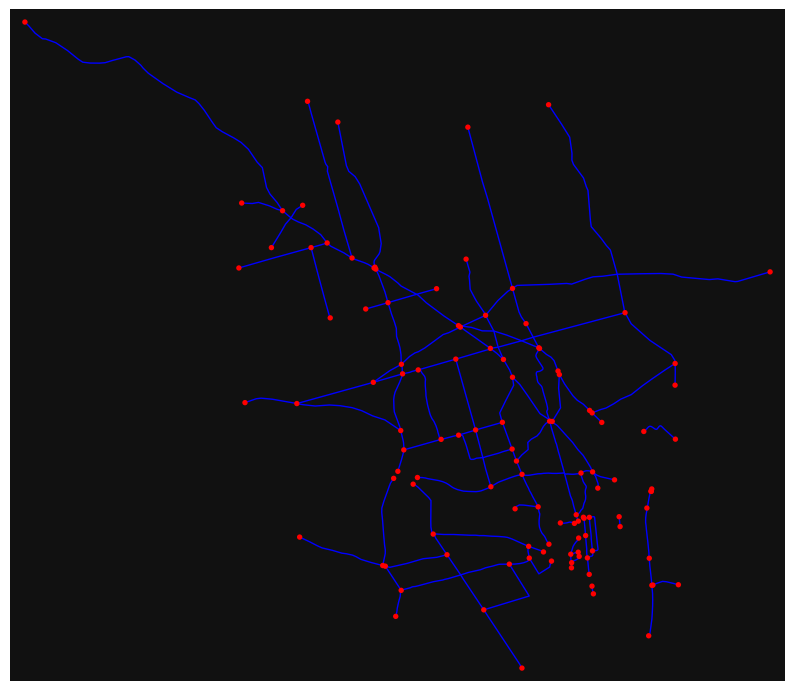

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [20]:
# Step 6: Visualization (optional)
ox.plot_graph(G, node_color="red", edge_color="blue", figsize=(10, 10))